# 混合ガウスモデルによるクラスタリングのJulia実装
---

# toy dataの生成

Ground Truthからtoy dataをサンプリングする

In [1]:
using PDMats
using Distributions
using LinearAlgebra
using Plots
using ProgressBars

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1242
┌ Warning: Module JSON with build ID 1290864591119004 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Info: Skipping precompilation since __precompile__(false). Importing Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80].
└ @ Base loading.jl:1017


In [2]:
μ1_gt = [0.; 5.]
μ2_gt = [-5.; 2.]
μ3_gt = [5.; -2.]

Σ1_gt = [1. 0.; 0. 2.]
Σ2_gt = [.5 .75; .75 2.]
Σ3_gt = [.5 .1; .1 .5]

π_gt = [.4, .35, .25]

mixture_components = MvNormal[
    MvNormal(μ1_gt, Σ1_gt), 
    MvNormal(μ2_gt, Σ2_gt), 
    MvNormal(μ3_gt, Σ3_gt)
];

model_gt = MixtureModel(mixture_components, π_gt)

MixtureModel{MvNormal}(K = 3)
components[1] (prior = 0.4000): FullNormal(
dim: 2
μ: [0.0, 5.0]
Σ: [1.0 0.0; 0.0 2.0]
)

components[2] (prior = 0.3500): FullNormal(
dim: 2
μ: [-5.0, 2.0]
Σ: [0.5 0.75; 0.75 2.0]
)

components[3] (prior = 0.2500): FullNormal(
dim: 2
μ: [5.0, -2.0]
Σ: [0.5 0.1; 0.1 0.5]
)



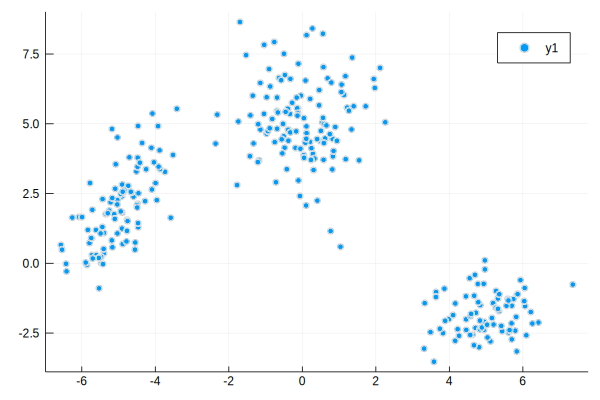

In [3]:
N = 300

x_train = rand(model_gt, N)
scatter(x_train[1, :], x_train[2, :])

# GMMを表現する構造体を作る

In [4]:
struct Gauss
    μ::Vector{Float64} # Mean Vector
    Λ::Matrix{Float64} # Precision Matrix
end

struct GMM
    D::Int
    K::Int
    mixing_coeff::Vector{Float64}
    components::Vector{Gauss}
end

GMMの可視化用の関数

In [5]:
function plot_contours(gmm::GMM)
    mvnormals = MvNormal[
        MvNormal(
            gmm.components[k].μ, 
            PDMat(Symmetric(inv(gmm.components[k].Λ)))
        ) for k in 1:gmm.K]
    
    for k in 1:gmm.K
        contour!(-10:0.05:10, -10:0.05:10, (x,y)->pdf(mvnormals[k], [x,y]), color=k, colorbar=:none)
    end
end

plot_contours (generic function with 1 method)

## ハイパーパラメタの準備

今回はクラスタ数が既知のクラスタリングを考える．

In [6]:
# Number of Classes
K = 3;

# Number of Dimensions
D = 2;

クラスタごとに別々の事前分布を設定することもできるが，ここでは全てのクラスタに同じ事前分布を設定している．

In [7]:
α0 = ones(K)
μ0 = zeros(D)
β0 = 1.0
ν0 = convert(Float64, D)
W0 = Matrix{Float64}(I, D, D)

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

## 潜在変数の準備

潜在変数の初期値は事前分布からサンプリングする

In [8]:
mixing_coeff = rand(Dirichlet(α0))

μk = zeros(K, D)
Λk = zeros(K, D, D)

for k in 1:K
    Λk[k, :, :] = rand(Wishart(ν0, W0))
    μk[k, :] = rand(MvNormal(μ0, PDMat(Symmetric(inv(β0 * Λk[k, :, :])))))
end

gaussians = Gauss[Gauss(μk[k, :], Λk[k, :, :]) for k in 1:K]

3-element Array{Gauss,1}:
 Gauss([0.4046659883960806, -0.961654220772715], [0.3491312112906832 -0.18671843604507998; -0.18671843604507998 1.3302493708829108])
 Gauss([-0.12743218086454364, -0.7531103819114536], [4.421280938918708 1.255419955187791; 1.255419955187791 2.1938636944792997])    
 Gauss([-1.4866787608894032, -2.088343842220474], [1.751304088346409 -2.0692139326517136; -2.0692139326517136 2.904788349160639])   

In [9]:
gmm = GMM(D, K, mixing_coeff, gaussians)
hidden_state = rand(Categorical(gmm.mixing_coeff), N);

データとクラスタの初期割当をプロット

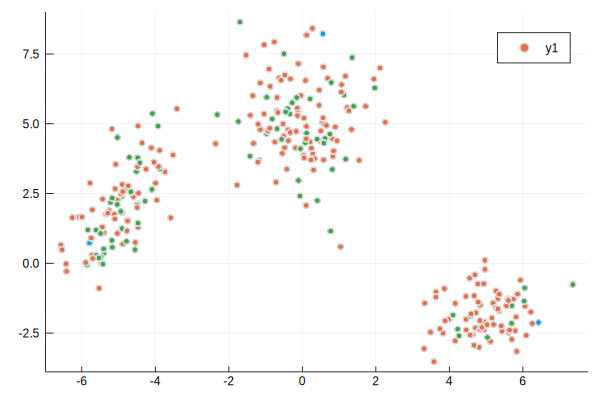

In [10]:
plt = plot()
scatter!(x_train[1, :], x_train[2, :], markercolor=hidden_state)

# ギプスサンプリングの実装

## GMMの対数同時確率の計算

事後確率最大化に使う

In [11]:
function compute_log_likelihood(gmm::GMM, x_train::Array{Float64}, hidden_state::Array{Int64, 1})
    
    log_lik = 0.0
    
    mvnormals = MvNormal[
        MvNormal(
            gmm.components[k].μ, 
            PDMat(Symmetric(inv(gmm.components[k].Λ)))
        ) for k in 1:K
    ]
    
    for n in 1:N
        log_lik += logpdf(mvnormals[hidden_state[n]], x_train[:, n])
        log_lik += logpdf(Categorical(gmm.mixing_coeff), hidden_state[hidden_state[n]])
    end

    # Log likelihood of Normal-Wishart
    for k in 1:K
        log_lik += logpdf(MvNormal(μ0, PDMat(Symmetric(inv(gmm.components[k].Λ)))), gmm.components[k].μ)
        log_lik += logpdf(Wishart(ν0, W0), gmm.components[k].Λ)
    end

    log_lik += logpdf(Dirichlet(α0), gmm.mixing_coeff)
    
    return log_lik
end

compute_log_likelihood (generic function with 1 method)

### クラスタ割り当てのサンプリング

In [12]:
function sample_hidden_state(gmm::GMM, x_train::Array{Float64})
    hidden_sttate = zeros(Int32, N)
    
    mvnormals = MvNormal[
        MvNormal(
            gmm.components[k].μ, 
            PDMat(Symmetric(inv(gmm.components[k].Λ)))
        ) for k in 1:K]
    
    # temporary variable
    p_xi = zeros(N, K)

    for k in 1:K
        p_xi[:, k] = pdf(mvnormals[k], x_train)
    end

    for n in 1:N
        p_xi[n, :] .*= gmm.mixing_coeff
    end

    for n in 1:N
        mixing_coeff_post = p_xi[n, :] / sum(p_xi[n, :])
        hidden_state[n] = rand(Categorical(mixing_coeff_post))
    end
    
    return hidden_state
end

sample_hidden_state (generic function with 1 method)

### 混合係数 $\pi$ のサンプリング

In [13]:
function sample_mixing_coeff(gmm::GMM, hidden_state::Array{Int64,1})
    state_ids = Array{Int64,1}(1:gmm.K)
    m = [count(x -> x == i, hidden_state) for i in state_ids]
    
    α_post = α0 + m
    new_mixing_coeff = rand(Dirichlet(α_post))
    
    return GMM(gmm.D, gmm.K, new_mixing_coeff, gmm.components)
end

sample_mixing_coeff (generic function with 1 method)

### ガウス分布のパラメタ $\mu_k$ と $\Lambda_k$ のサンプリング

In [14]:
function sample_gauss(gmm::GMM, x_train::Array{Float64}, hidden_state::Array{Int64,1})
    new_μk = zeros(K, D)
    new_Λk = zeros(K, D, D)

    # temporary variables
    state_ids = Array{Int64,1}(1:gmm.K)
    m = [count(x -> x == i, hidden_state) for i in state_ids]

    for k in 1:K
        # Get data in the k-th class
        x_k = x_train[:, hidden_state .== k]
        # Compute the covariance matrix of the k-th class
        S_k = x_k * x_k'

        # Compute parameters of posterior distributions
        β_post = β0 + m[k]
        μ_post = (sum(x_k, dims=2) + β0 * μ0) / β_post
        μ_post = μ_post[:, 1]

        ν_post = ν0 + m[k]
        W_post_inv = S_k + β0 * μ0 * μ0' - β_post * μ_post * μ_post' + inv(W0)
        W_post = PDMat(Symmetric(inv(W_post_inv)))
        
        # Sample parameters from posterior distributions
        new_Λk[k, :, :] = rand(Wishart(ν_post, W_post))
        new_μk[k, :] = rand(MvNormal(μ_post, PDMat(Symmetric(inv(β_post * new_Λk[k, :, :])))))
    end
    
    new_components = Gauss[Gauss(new_μk[k, :], new_Λk[k, :, :]) for k in 1:K]
    
    return GMM(gmm.D, gmm.K, gmm.mixing_coeff, new_components)
end

sample_gauss (generic function with 1 method)

# Gibbs Samplingの実行とアニメーションの生成

アニメーション生成の参考

https://qiita.com/Lirimy/items/8976bb4dcf5febad178e

In [15]:
# 対数同時確率を最大にするパラメタとクラス割当て，そのときの対数事後確率を保存する
gmm_max = deepcopy(gmm)
hidden_state_max = copy(hidden_state)
loglik_max = compute_log_likelihood(gmm, x_train, hidden_state)

-15526.07186386672

In [16]:
loglik_list = Array{Float64, 1}()

0-element Array{Float64,1}

In [17]:
anim = Animation()

# 初期状態のプロット
plt = scatter(x_train[1, :], x_train[2, :], markercolor=hidden_state, legend=:none)
plot_contours(gmm)
title!("Iteration: 0")
frame(anim, plt)

for iter in tqdm(1:200)
    # クラスタ割り当てのサンプリング
    hidden_state = sample_hidden_state(gmm, x_train)
    # 混合係数のサンプリング
    gmm = sample_mixing_coeff(gmm, hidden_state)
    # ガウス分布のパラメタのサンプリング
    gmm = sample_gauss(gmm, x_train, hidden_state)
    
    loglik = compute_log_likelihood(gmm, x_train, hidden_state)
    
    if loglik > loglik_max
        gmm_max = deepcopy(gmm)
        hidden_state_max = copy(hidden_state)
        loglik_max = compute_log_likelihood(gmm, x_train, hidden_state)
    end
    
    push!(loglik_list, loglik)
    
    # ギプスサンプリングの現在の状態をプロット
    plt = plot()
    scatter!(x_train[1, :], x_train[2, :], markercolor=hidden_state, legend=:none)
    plot_contours(gmm)
    title!("Iteration: $iter")
    frame(anim, plt)
end

gif(anim, "gs_gmm.gif", fps=4);

100.00%┣███████████████████████████████████████████████████████████▉┫ 199/200 03:35<00:01, 0.92 it/s]┫ 1/200 00:10<Inf:Inf, 0.00 it/s]┫ 2/200 00:11<37:31, 0.09 it/s]3/200 00:12<20:21, 0.16 it/s]5/200 00:14<11:45, 0.28 it/s]6/200 00:15<10:00, 0.32 it/s]9/200 00:18<07:17, 0.44 it/s]12/200 00:23<06:26, 0.49 it/s]15/200 00:25<05:34, 0.55 it/s]17/200 00:28<05:15, 0.58 it/s]19/200 00:29<04:56, 0.61 it/s]21/200 00:32<04:44, 0.63 it/s]22/200 00:33<04:38, 0.64 it/s]23/200 00:34<04:32, 0.65 it/s]┫ 24/200 00:35<04:26, 0.66 it/s]31/200 00:42<03:56, 0.72 it/s]32/200 00:43<03:55, 0.72 it/s]33/200 00:44<03:51, 0.72 it/s]34/200 00:45<03:47, 0.73 it/s]37/200 00:48<03:38, 0.75 it/s]40/200 00:52<03:33, 0.75 it/s]41/200 00:53<03:30, 0.76 it/s]44/200 00:56<03:22, 0.77 it/s]45/200 00:57<03:21, 0.77 it/s]46/200 00:58<03:20, 0.77 it/s]48/200 01:00<03:15, 0.78 it/s]49/200 01:01<03:13, 0.78 it/s]50/200 01:02<03:11, 0.79 it/s]51/200 01:03<03:08, 0.79 it/s]52/200 01:04<03:05, 0.80 it/s]54/200 01:06<03:01, 0.81 it

┌ Info: Saved animation to 
│   fn = C:\Users\chikuwa\workspace\julia-work\gs_gmm.gif
└ @ Plots C:\Users\chikuwa\.julia\packages\Plots\Ih71u\src\animation.jl:95


対数事後確率のプロット

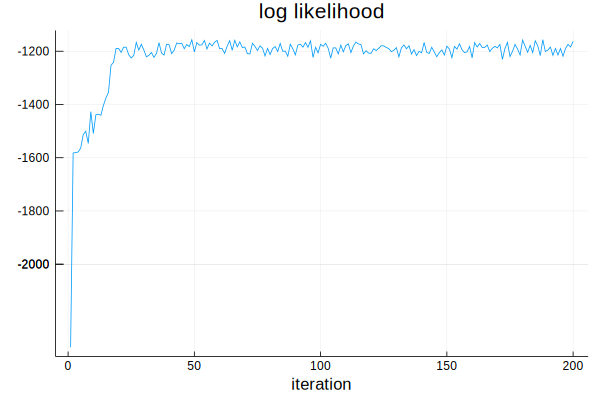

In [18]:
plot(loglik_list, legend=:none, title="log likelihood", xlabel="iteration")

Gibbsサンプリングの過程の可視化

![gs_gmm](gs_gmm.gif)

最終結果

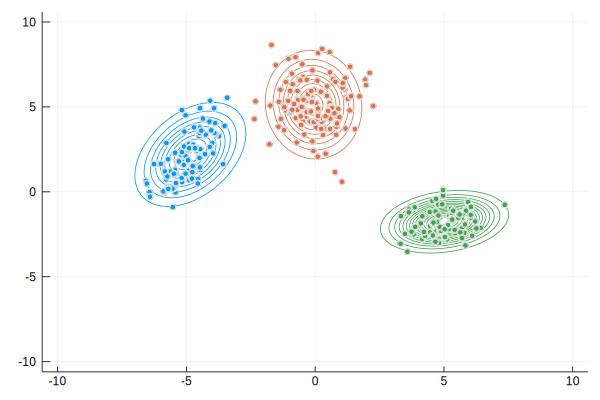

In [19]:
plt = plot()
plot_contours(gmm_max)
scatter!(x_train[1, :], x_train[2, :], markercolor=hidden_state, legend=:none)

In [20]:
gmm_max

GMM(2, 3, [0.31808502242344944, 0.4646838504405655, 0.21723112713598516], Gauss[Gauss([-4.845043218564879, 2.201609727235379], [1.1755058721930913 -0.3351624941394205; -0.3351624941394205 0.5820149230408094]), Gauss([-0.062440489382527574, 5.134625658497423], [1.303220469727405 0.038156905022820126; 0.038156905022820126 0.4474145186378794]), Gauss([5.0192664590204705, -1.7609293591790838], [0.9437098896474538 -0.28511133861479226; -0.28511133861479226 1.71965348616064])])